<div style="border: 2px solid #0066cc; padding: 15px; border-radius: 10px; background-color: #f8f9fa; text-align: center; color: #333; font-weight: bold;">

# **Retail Inventory Management System - LangGraph AGILE Implementation**

</div>

## 📊 **Overview**
This project demonstrates a **multi-agent workflow** for building a **Retail Inventory Management System** using the **Waterfall methodology**. Leveraging **LangGraph's agent framework**, each specialized AI agent contributes to a distinct phase, from **requirements gathering** to **final deployment**.

# Setting Up the LangGraph Waterfall Project

Import the required libraries:

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any, Literal, Union, Optional
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
import os
import re
import time
import json
from fpdf import FPDF
from dotenv import load_dotenv

# OpenAI Integration Setup

- Loading API credentials securely using `dotenv.load_dotenv()`.
- Configuring `llm_config` to use the `"gpt-4o-mini"` model with an API key from environment variables.

In [3]:
# Load environment variables
_ = load_dotenv()

# Set up OpenAI client
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=api_key)

### **Below is the complete set of AI agent prompts for the LangGraph-based Retail Inventory Management System following the Waterfall methodology.**

In [4]:
# === System Prompts for LangGraph Agile Scrum Agents ===

CUSTOMER_PROMPT = """You are a Customer Proxy agent representing retail stakeholders. 

### Role:
- Clearly articulate business expectations and user pain points to the Scrum team.
- Collaborate with the Product Owner to validate deliverables.
- Provide feedback and approvals at the end of each sprint.

### Business Context:
You represent a coffee retail business that requires an **AI-powered Inventory Management System (IMS)** with the following capabilities:
1. Real-time inventory tracking.
2. AI-driven stock shortage predictions and reorder point suggestions.
3. Automated reordering workflows.
4. Multi-warehouse inventory support.
5. Detailed reporting on stock movement and trends.
"""

PRODUCT_OWNER_PROMPT = """You are a Product Owner on an Agile Scrum team.

### Responsibilities:
- Translate Customer Proxy goals into user stories and prioritize them in the backlog.
- Define sprint goals, scope, and deliverables.
- Ensure clarity in product requirements and alignment with stakeholder expectations.
- Work closely with other roles to enable successful sprint execution.

### Deliverables:
- Product backlog (user stories with priorities).
- Sprint plan (goals, estimates, blockers).
- Stakeholder feedback response and change proposals.
"""

SCRUM_MASTER_PROMPT = """You are the Scrum Master facilitating Agile ceremonies.

### Responsibilities:
- Organize and run daily standups, sprint planning, reviews, and retrospectives.
- Ensure adherence to Agile principles.
- Track velocity and unblock team members.
- Foster a culture of transparency and improvement.

### Deliverables:
- Summary of ceremonies and team coordination.
- Blockers and resolution strategies.
"""

BUSINESS_ANALYST_PROMPT = """You are a Business Analyst collaborating with the Product Owner.

### Responsibilities:
- Refine user stories with detailed requirements and edge cases.
- Specify functional and non-functional criteria.
- Align features with business goals and regulatory constraints.

### Deliverables:
- Fully detailed user stories.
- Acceptance criteria, personas, edge cases.
- Planning inputs for productivity and workload.
"""

ARCHITECT_PROMPT = """You are a System Architect responsible for solution design.

### Responsibilities:
- Map user stories to system components and interfaces.
- Create diagrams for architecture, APIs, and data models.
- Anticipate scalability and integration challenges.

### Deliverables:
- Architecture blueprint (components, DB, APIs).
- Risks, assumptions, and scalability plans.
- Metrics-driven rework plans if needed.
"""

DEVELOPER_PROMPT = """You are a Developer building the system features.

### Responsibilities:
- Implement features from the sprint backlog.
- Collaborate with QA, PO, and UI/UX to ensure testability and usability.
- Provide technical estimates and progress metrics.

### Deliverables:
- Feature implementation with modular code.
- Estimated SLOC, productivity rate (SLOC/day), developers assigned.
- Calculated Effort = SLOC / ProductivityRate
- Calculated Duration = Effort / Developers
- Sprint burndown progress report.
"""

UI_UX_DESIGNER_PROMPT = """You are a UI/UX Designer focused on usability.

### Responsibilities:
- Design intuitive interfaces with accessibility and responsiveness.
- Work with Business Analyst and PO to visualize user journeys.

### Deliverables:
- Wireframes and final designs.
- Design effort estimates and iteration feedback.
"""

QA_ENGINEER_PROMPT = """You are a QA Engineer validating software quality.

### Responsibilities:
- Write and execute test plans.
- Conduct functional, regression, and edge case testing.
- Track and prioritize defects.

### Deliverables:
- Test case suite with coverage metrics.
- Defect backlog or QA sign-off.
- Daily test report during sprints.
"""

DEVOPS_ENGINEER_PROMPT = """You are a DevOps Engineer managing build and deployment.

### Responsibilities:
- Build and maintain CI/CD pipelines.
- Ensure environment readiness and reliability.
- Automate deployments and monitor pipeline health.

### Deliverables:
- Sprint-based deployment plan.
- Pipeline success/failure metrics.
- Environment uptime and rollback readiness.
"""

SECURITY_ENGINEER_PROMPT = """You are a Security Engineer securing the pipeline and platform.

### Responsibilities:
- Perform static/dynamic code scans.
- Identify vulnerabilities in CI/CD and runtime.
- Ensure compliance with security standards.

### Deliverables:
- Security scan results and threat models.
- Patch checklists and mitigation strategies.
"""

TECHNICAL_WRITER_PROMPT = """You are a Technical Writer documenting the entire product lifecycle.

### Responsibilities:
- Write user documentation, API references, and release notes.
- Work with developers and QA to capture accurate functionality.

### Deliverables:
- Version-controlled user guides and technical docs.
- Documentation updates per sprint and final product manual.
"""

### State definition

In [5]:
class ScrumState(TypedDict):
    customer_req: str
    customer_prompt: Optional[str]
    product_backlog: str
    sprint_backlog: str
    user_stories_doc: str
    design_notes: str
    dev_tasks: List[str]
    test_cases: List[str]
    documentation_notes: str
    sprint_report: str
    current_phase: str
    phase_outputs: Dict[str, str]
    conversation_history: List[Dict[str, str]]
    metrics: Dict[str, Any]
    analysis_summary: str
    human_feedback: str
    rework_needed: bool
    rework_phase: Optional[str]
    feedback_loop_count: int
    completion_status: Literal["in_progress", "completed"]

In [6]:
### State definition for Agile approach
class ScrumState(TypedDict):
    customer_req: str
    customer_prompt: Optional[str]
    product_backlog: str
    sprint_backlog: str
    user_stories_doc: str
    design_notes: str
    dev_tasks: List[str]
    test_cases: List[str]
    documentation_notes: str
    sprint_report: str
    current_phase: str
    phase_outputs: Dict[str, str]
    conversation_history: List[Dict[str, str]]
    metrics: Dict[str, Any]
    analysis_summary: str
    human_feedback: str
    rework_needed: bool
    rework_phase: Optional[str]
    feedback_loop_count: int
    completion_status: Literal["in_progress", "completed"]

# === Utilities ===
def print_agent_response(agent_name, response):
    print("\n" + "=" * 80)
    print(f"🤖 {agent_name} RESPONSE:")
    print("-" * 80)
    print(response)
    print("=" * 80)

# Node functions for Agile implementation
def get_customer_requirements(state: ScrumState):
    """Get initial customer requirements from user input"""
    print("\n" + "=" * 80)
    print("🧑‍💼 CUSTOMER REQUIREMENTS PHASE")
    print("=" * 80)
    print("\nPlease enter your specific requirements for the Inventory Management System:")
    customer_input = input("Please enter your specific requirements for the Inventory Management System for Retailer:")
    
    # Use the customer input to generate a more detailed requirements document
    if customer_input.strip():
        messages = [
            SystemMessage(content=CUSTOMER_PROMPT),
            HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
        ]
    else:
        customer_input = "I need an inventory management system that can track stock levels in real-time, predict when we'll run out of items, and automatically place orders when stock is low."
        print(f"\nUsing default requirements: '{customer_input}'")
        messages = [
            SystemMessage(content=CUSTOMER_PROMPT),
            HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
        ]
    
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("CUSTOMER PROXY", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Human_Customer",
        "content": customer_input
    })
    conversation.append({
        "role": "Customer_Proxy",
        "content": response.content
    })
    
    return {
        "customer_req": response.content,
        "customer_prompt": customer_input,
        "current_phase": "requirements_gathering",
        "conversation_history": conversation,
        "phase_outputs": {"Customer_Proxy": response.content},
        "rework_needed": False,
        "feedback_loop_count": 0,
        "completion_status": "in_progress"
    }

def product_backlog_node(state: ScrumState):
    """Product Owner creates the product backlog"""
    print("\n" + "=" * 80)
    print("🧑‍💼 PRODUCT BACKLOG CREATION PHASE")
    print("=" * 80)

    # Avoid regenerating if already exists and no rework is needed
    if state.get("product_backlog") and not state.get("rework_needed", False):
        print("⚠️ Skipping backlog generation. Already exists and no rework is required.")
        return state
    
    messages = [
        SystemMessage(content=PRODUCT_OWNER_PROMPT),
        HumanMessage(content=f"Based on the following customer requirements, create a prioritized product backlog with user stories for the Inventory Management System:\n\n{state['customer_req']}")
    ]
    
    if state.get("rework_needed") and state.get("human_feedback"):
        messages.append(HumanMessage(content=f"Please revise your product backlog based on this feedback:\n\n{state['human_feedback']}"))
    
    response = model.invoke(messages)
    print_agent_response("PRODUCT OWNER", response.content)
    
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Product_Owner",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Product_Owner"] = response.content
    
    return {
        "product_backlog": response.content,
        "current_phase": "product_backlog_creation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs,
        "rework_needed": False,
        "rework_phase": None
    }

def get_stakeholder_feedback(state: ScrumState):
    print("\n" + "=" * 80)
    print("🧑‍💼 STAKEHOLDER FEEDBACK REQUIRED")
    print("=" * 80)

    print("\nThe Product Owner has created the following product backlog:")
    print("-" * 50)
    print(state["product_backlog"])
    print("-" * 50)

    print("\nWhat do you think about this product backlog?")
    print("1. Approve and continue to sprint planning")
    print("2. Request changes (provide feedback)")
    print("3. View customer requirements")

    choice = input("\nEnter your choice (1-3): ")

    if choice == "3":
        print("\n==== ORIGINAL CUSTOMER REQUIREMENTS ====")
        print(state["customer_req"])
        print("-" * 50)
        return get_stakeholder_feedback(state)

    if choice == "2":
        print("\nPlease provide your feedback for the product owner:")
        feedback = input("> ")
        conversation = state.get("conversation_history", [])
        conversation.append({
            "role": "Human_Stakeholder",
            "content": feedback
        })
        return {
            "human_feedback": feedback,
            "rework_needed": True,
            "rework_phase": "product_backlog_creation",
            "feedback_loop_count": state.get("feedback_loop_count", 0) + 1,
            "conversation_history": conversation
        }

    # Approved
    print("\n✅ Product backlog approved. Moving to sprint planning phase...")
    return {
        "rework_needed": False,
        "human_feedback": "Product backlog approved",
        "rework_phase": None,
        "current_phase": "product_backlog_approved"
    }

def sprint_planning_node(state: ScrumState):
    """Scrum Master facilitates sprint planning from customer requirements directly"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SPRINT PLANNING PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SCRUM_MASTER_PROMPT),
        HumanMessage(content=f"""Facilitate a sprint planning session based on the following customer requirements. 
        Create a sprint backlog with prioritized items and effort estimates (story points).
        
        Customer Requirements:
        {state['customer_req']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SCRUM MASTER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Scrum_Master",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Scrum_Master"] = response.content
    
    return {
        "sprint_backlog": response.content,
        "current_phase": "sprint_planning",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def user_stories_node(state: ScrumState):
    """Business Analyst refines user stories"""
    print("\n" + "=" * 80)
    print("🧑‍💼 USER STORIES REFINEMENT PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=BUSINESS_ANALYST_PROMPT),
        HumanMessage(content=f"""Based on the following sprint backlog, refine the user stories with detailed acceptance criteria.

Sprint Backlog:
{state['sprint_backlog']}
""")
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("BUSINESS ANALYST", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Business_Analyst",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Business_Analyst"] = response.content
    
    return {
        "user_stories_doc": response.content,
        "current_phase": "user_stories_refinement",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def architecture_design_node(state: ScrumState):
    """Architect defines the technical design"""
    print("\n" + "=" * 80)
    print("🧑‍💼 ARCHITECTURE DESIGN PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=ARCHITECT_PROMPT),
        HumanMessage(content=f"""Create an architectural design based on the following user stories.
        
        User Stories:
        {state['user_stories_doc']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SYSTEM ARCHITECT", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "System_Architect",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["System_Architect"] = response.content
    
    return {
        "design_notes": response.content,
        "current_phase": "architecture_design",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def ui_design_node(state: ScrumState):
    """UI/UX Designer creates the interface design"""
    print("\n" + "=" * 80)
    print("🧑‍💼 UI/UX DESIGN PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=UI_UX_DESIGNER_PROMPT),
        HumanMessage(content=f"""Create wireframes and interface designs based on the following user stories and architectural design.
        
        User Stories:
        {state['user_stories_doc']}
        
        Architecture Design:
        {state['design_notes']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("UI/UX DESIGNER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "UI_UX_Designer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["UI_UX_Designer"] = response.content
    
    # Add to design notes
    design_notes = state.get("design_notes", "") + "\n\n## UI/UX Design\n" + response.content
    
    return {
        "design_notes": design_notes,
        "current_phase": "ui_ux_design",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def development_node(state: ScrumState):
    """Developer implements the features"""
    print("\n" + "=" * 80)
    print("🧑‍💼 DEVELOPMENT PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=DEVELOPER_PROMPT),
        HumanMessage(content=f"""Implement the features based on the following user stories and designs.
        
        User Stories:
        {state['user_stories_doc']}
        
        Designs:
        {state['design_notes']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("DEVELOPER", response.content)
    
    # Extract code sections from the response
    code_sections = re.findall(r'```(?:\w+)?\s*([\s\S]*?)```', response.content)
    dev_tasks = [section.strip() for section in code_sections if section.strip()]
    
    if not dev_tasks:
        dev_tasks = ["Implementation tasks extracted from developer response"]
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Developer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Developer"] = response.content
    
    return {
        "dev_tasks": dev_tasks,
        "current_phase": "development",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def devops_node(state: ScrumState):
    """DevOps Engineer sets up the CI/CD pipeline"""
    print("\n" + "=" * 80)
    print("🧑‍💼 DEVOPS PHASE")
    print("=" * 80)
    
    # Join the dev tasks into a string for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    
    messages = [
        SystemMessage(content=DEVOPS_ENGINEER_PROMPT),
        HumanMessage(content=f"""Create CI/CD pipelines and deployment strategies for the following implementation.
        
        Implementation:
        {dev_tasks_str}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("DEVOPS ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "DevOps_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["DevOps_Engineer"] = response.content
    
    return {
        "current_phase": "devops",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def security_node(state: ScrumState):
    """Security Engineer performs security assessment"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SECURITY ASSESSMENT PHASE")
    print("=" * 80)
    
    # Join the dev tasks into a string for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    
    messages = [
        SystemMessage(content=SECURITY_ENGINEER_PROMPT),
        HumanMessage(content=f"""Perform a security assessment for the following implementation.
        
        Implementation:
        {dev_tasks_str}
        
        DevOps Configuration:
        {state['phase_outputs'].get('DevOps_Engineer', '')}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SECURITY ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Security_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Security_Engineer"] = response.content
    
    return {
        "current_phase": "security_assessment",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def testing_node(state: ScrumState):
    """QA Engineer creates and executes test cases"""
    print("\n" + "=" * 80)
    print("🧑‍💼 TESTING PHASE")
    print("=" * 80)
    
    # Join the dev tasks into a string for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    
    messages = [
        SystemMessage(content=QA_ENGINEER_PROMPT),
        HumanMessage(content=f"""Create and execute test cases for the following implementation.
        
        User Stories:
        {state['user_stories_doc']}
        
        Implementation:
        {dev_tasks_str}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("QA ENGINEER", response.content)
    
    # Extract test cases from the response
    test_sections = re.findall(r'(Test Case \d+[\s\S]*?)(?=Test Case \d+|$)', response.content)
    test_cases = [section.strip() for section in test_sections if section.strip()]
    
    if not test_cases:
        test_cases = ["Test cases extracted from QA response"]
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "QA_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["QA_Engineer"] = response.content
    
    return {
        "test_cases": test_cases,
        "current_phase": "testing",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def documentation_node(state: ScrumState):
    """Technical Writer creates documentation"""
    print("\n" + "=" * 80)
    print("🧑‍💼 DOCUMENTATION PHASE")
    print("=" * 80)
    
    # Join the dev tasks and test cases into strings for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    test_cases_str = "\n".join(state.get("test_cases", []))
    
    messages = [
        SystemMessage(content=TECHNICAL_WRITER_PROMPT),
        HumanMessage(content=f"""Create technical documentation for the following implementation.
        
        User Stories:
        {state['user_stories_doc']}
        
        Implementation:
        {dev_tasks_str}
        
        Test Cases:
        {test_cases_str}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("TECHNICAL WRITER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Technical_Writer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Technical_Writer"] = response.content
    
    return {
        "documentation_notes": response.content,
        "current_phase": "documentation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def sprint_review_node(state: ScrumState):
    """Scrum Master facilitates the sprint review"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SPRINT REVIEW PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SCRUM_MASTER_PROMPT),
        HumanMessage(content=f"""Facilitate a sprint review for the completed sprint.
        
        Sprint Backlog:
        {state['sprint_backlog']}
        
        Development Results:
        {state['phase_outputs'].get('Developer', '')}
        
        Testing Results:
        {state['phase_outputs'].get('QA_Engineer', '')}
        
        Documentation:
        {state['documentation_notes']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SCRUM MASTER (SPRINT REVIEW)", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Scrum_Master_Review",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Sprint_Review"] = response.content
    
    return {
        "sprint_report": response.content,
        "current_phase": "sprint_review",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def sprint_retrospective_node(state: ScrumState):
    """Scrum Master facilitates the sprint retrospective"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SPRINT RETROSPECTIVE PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SCRUM_MASTER_PROMPT),
        HumanMessage(content=f"""Facilitate a sprint retrospective for the completed sprint.
        
        Sprint Review:
        {state['sprint_report']}
        
        What went well, what could be improved, and action items for the next sprint.
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SCRUM MASTER (RETROSPECTIVE)", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Scrum_Master_Retro",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Sprint_Retrospective"] = response.content
    
    return {
        "current_phase": "sprint_retrospective",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def stakeholder_demo_approval(state: ScrumState):
    """Get stakeholder approval on the completed sprint"""
    print("\n" + "=" * 80)
    print("🧑‍💼 STAKEHOLDER DEMO & APPROVAL")
    print("=" * 80)
    
    print("\nThe sprint has been completed. Here's a summary of what was accomplished:")
    print("-" * 50)
    print(state["sprint_report"])
    print("-" * 50)
    
    print("\nDo you approve the sprint results?")
    print("1. Approve and generate final metrics")
    print("2. View more details about the sprint")
    
    choice = input("\nEnter your choice (1-2): ")
    
    if choice == "2":
        print("\n=== SPRINT DETAILS ===")
        print("1. User Stories")
        print("2. Development Tasks")
        print("3. Test Cases")
        print("4. Documentation")
        print("5. Sprint Review")
        print("6. Sprint Retrospective")
        
        detail_choice = input("\nEnter detail number to view (1-6): ")
        detail_map = {
            "1": ("User Stories", state.get("user_stories_doc", "Not available")),
            "2": ("Development Tasks", "\n".join(state.get("dev_tasks", ["Not available"]))),
            "3": ("Test Cases", "\n".join(state.get("test_cases", ["Not available"]))),
            "4": ("Documentation", state.get("documentation_notes", "Not available")),
            "5": ("Sprint Review", state.get("sprint_report", "Not available")),
            "6": ("Sprint Retrospective", state.get("phase_outputs", {}).get("Sprint_Retrospective", "Not available"))
        }
        
        if detail_choice in detail_map:
            title, content = detail_map[detail_choice]
            print(f"\n==== {title} ====")
            print(content)
            print("-" * 50)
        
        return stakeholder_demo_approval(state)
    
    # Default to option 1 (approve) for any other input
    print("\nSprint approved. Generating sprint metrics...")
    return {
        "current_phase": "sprint_approved",
        "completion_status": "completed"
    }

# Error handling for PDF generation
def generate_report_node(state: ScrumState):
    """Generate a comprehensive sprint report with PDF"""
    print("\n" + "=" * 80)
    print("📄 GENERATING SPRINT REPORT")
    print("=" * 80)
    
    # Create a PDF report
    try:
        pdf = FPDF()
        pdf.add_page()
        
        # Set up title
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Retail Inventory Management System - Sprint Report", ln=True, align="C")
        pdf.ln(10)
        
        # Add customer requirements
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Customer Requirements:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("customer_req", "")[:500] + "...")
        pdf.ln(5)
        
        # Add sprint backlog
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Backlog:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("sprint_backlog", "")[:500] + "...")
        pdf.ln(5)
        
        # Add sprint metrics
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Metrics:", ln=True)
        pdf.set_font("Arial", "", 10)
        metrics = state.get("metrics", {})
        
        metrics_text = f"""
User Stories: {metrics.get('user_stories', {}).get('count', 0)}
Story Points: {metrics.get('user_stories', {}).get('story_points', 0)}
Development Tasks: {metrics.get('development', {}).get('tasks', 0)}
Test Cases: {metrics.get('testing', {}).get('test_cases', 0)}
Bugs Found: {metrics.get('testing', {}).get('bugs_found', 0)}
Bugs Fixed: {metrics.get('testing', {}).get('bugs_fixed', 0)}
Documentation Pages: {metrics.get('documentation', {}).get('pages', 0)}
        """
        pdf.multi_cell(0, 5, metrics_text)
        pdf.ln(5)
        
        # Add sprint report
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Report:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("analysis_summary", ""))
        
        # Save the PDF
        pdf_path = "sprint_report.pdf"
        pdf.output(pdf_path)
        print(f"\n📄 PDF REPORT SAVED: {pdf_path}")
        
    except Exception as e:
        print(f"Error generating PDF report: {e}")
        print("Continuing with text report only...")
    
    return {
        "current_phase": "report_generated"
    }

def should_rework(state: ScrumState):
    """Determine if rework is needed based on feedback"""
    return state.get("rework_needed", False)

def get_rework_destination(state: ScrumState):
    """Return the rework phase destination"""
    rework_phase = state.get("rework_phase")
    if rework_phase == "product_backlog_creation":
        return "product_backlog_node"
    else:
        # Default fallback to prevent loops
        print("⚠️ Invalid rework phase specified, proceeding with normal flow")
        return "sprint_planning_node"
def generate_software_project_plan_node(state: ScrumState):
    """Use the LLM to generate a comprehensive software project plan summary"""
    print("\n" + "=" * 80)
    print("📘 FINAL SOFTWARE PROJECT PLAN")
    print("=" * 80)

    full_history = state.get("conversation_history", [])
    phase_outputs = state.get("phase_outputs", {})

    messages = [
        SystemMessage(content="""
You are a technical writer and software architect. You will now write a full, complete Software Project Plan 
for an AI-powered Retail Inventory Management System for a coffee retail company, based on everything done so far.
Summarize and combine insights from customer requirements, sprint outputs, architecture, UX, DevOps, QA, and documentation.

Include:
- Project objectives and scope
- Full list of features (not just sprinted)
- Final architecture and database design
- Dev plan with modules, estimates, and timeline
- Security, CI/CD, testing and documentation strategies
- Final effort, duration, productivity, and quality metrics

Also include a breakdown on how effort, duration, and productivity are calculated:
Example:
1. Let Work = 3000 SLOC
2. Effort will be calculated as:
   Work / Productivity Rate = 3000 / 100 SLOC/day = 30 days per 1 Head Count
3. Duration will be calculated as:
   Effort / # Head Count = 30 days / 1 HC = 30 days
   or, for 2 Head Counts: 30 days / 2 HC = 15 days
"""),
        HumanMessage(content=f"""Here are the outputs from all previous phases:
{json.dumps(phase_outputs, indent=2)}
""")
    ]

    response = model.invoke(messages)

    print_agent_response("TECHNICAL WRITER (FINAL PROJECT PLAN)", response.content)

    full_history.append({"role": "Project_Plan", "content": response.content})
    state["conversation_history"] = full_history
    state["final_project_plan"] = response.content
    state["analysis_summary"] = response.content
    state["current_phase"] = "project_plan"
    state["completion_status"] = "completed"

    return state
# === Additional Feedback Routers ===
def sprint_review_router(state: ScrumState) -> str:
    if state.get("rework_needed", False):
        # Allow stakeholder to loop back to development or testing
        rework_phase = state.get("rework_phase", "")
        if rework_phase == "development":
            return "development_node"
        elif rework_phase == "testing":
            return "testing_node"
        else:
            return "sprint_retrospective_node"  # default to retrospective
    else:
        return "sprint_retrospective_node"

def sprint_retro_router(state: ScrumState) -> str:
    # Optionally go back to sprint planning if action items indicate major change
    if state.get("rework_needed", False):
        return "sprint_planning_node"
    else:
        return "stakeholder_demo_approval"

def testing_feedback_router(state: ScrumState) -> str:
    # Loop to development if testing finds blockers
    if state.get("rework_needed", False):
        return "development_node"
    return "documentation_node"

# Build the Graph
builder = StateGraph(ScrumState)

# Nodes
builder.add_node("get_customer_requirements", get_customer_requirements)
builder.add_node("sprint_planning_node", sprint_planning_node)
builder.add_node("user_stories_node", user_stories_node)
builder.add_node("architecture_design_node", architecture_design_node)
builder.add_node("ui_design_node", ui_design_node)
builder.add_node("development_node", development_node)
builder.add_node("devops_node", devops_node)
builder.add_node("security_node", security_node)
builder.add_node("testing_node", testing_node)
builder.add_node("documentation_node", documentation_node)
builder.add_node("sprint_review_node", sprint_review_node)
builder.add_node("sprint_retrospective_node", sprint_retrospective_node)
builder.add_node("stakeholder_demo_approval", stakeholder_demo_approval)
# builder.add_node("extract_metrics_node", extract_metrics_node)
builder.add_node("generate_software_project_plan_node", generate_software_project_plan_node)


# Set the entry point
builder.set_entry_point("get_customer_requirements")
# Define conditional edges for feedback loops

builder.add_conditional_edges(
    "sprint_review_node",
    sprint_review_router,
    {
        "development_node": "development_node",
        "testing_node": "testing_node",
        "sprint_retrospective_node": "sprint_retrospective_node"
    }
)

builder.add_conditional_edges(
    "sprint_retrospective_node",
    sprint_retro_router,
    {
        "sprint_planning_node": "sprint_planning_node",
        "stakeholder_demo_approval": "stakeholder_demo_approval"
    }
)

builder.add_conditional_edges(
    "testing_node",
    testing_feedback_router,
    {
        "development_node": "development_node",
        "documentation_node": "documentation_node"
    }
)

# Main flow — simplified
builder.add_edge("get_customer_requirements", "sprint_planning_node")
builder.add_edge("sprint_planning_node", "user_stories_node")
builder.add_edge("user_stories_node", "architecture_design_node")
builder.add_edge("architecture_design_node", "ui_design_node")
builder.add_edge("ui_design_node", "development_node")
builder.add_edge("development_node", "devops_node")
builder.add_edge("devops_node", "security_node")
builder.add_edge("security_node", "testing_node")
builder.add_edge("testing_node", "documentation_node")
builder.add_edge("documentation_node", "sprint_review_node")
builder.add_edge("sprint_review_node", "sprint_retrospective_node")
builder.add_edge("sprint_retrospective_node", "stakeholder_demo_approval")
builder.add_edge("stakeholder_demo_approval", "generate_software_project_plan_node")

# Compile the graph
graph = builder.compile()

# Execute the graph with an empty initial state
initial_state = {
    "customer_req": "",
    "customer_prompt": "customer_req",
    "product_backlog": "",
    "sprint_backlog": "",
    "user_stories_doc": "",
    "design_notes": "",
    "dev_tasks": [],
    "test_cases": [],
    "documentation_notes": "",
    "sprint_report": "",
    "current_phase": "start",
    "phase_outputs": {},
    "conversation_history": [],
    "metrics": {},
    "analysis_summary": "",
    "human_feedback": "",
    "rework_needed": False,
    "rework_phase": None,
    "feedback_loop_count": 0,
    "completion_status": "in_progress"
}

# Run the workflow
def main():
    print("\n" + "=" * 80)
    print("🚀 RETAIL INVENTORY MANAGEMENT SYSTEM - AGILE IMPLEMENTATION")
    print("=" * 80)
    print("\nWelcome to the LangGraph Agile Implementation for Retail Inventory Management System")
    print("This workflow will guide you through an Agile Scrum process to create an inventory system")
    final_state = None
    for state in graph.stream(initial_state):
         final_state = state  # state is a dict containing the latest updated state

    if final_state:
            print("\n" + "=" * 80)
            print("✅ WORKFLOW COMPLETED")
            print("=" * 80)
            print(f"\nFinal state: {final_state.get('current_phase', 'N/A')}")
            print(f"Completion status: {final_state.get('completion_status', 'N/A')}")
            

if __name__ == "__main__":
    main()


🚀 RETAIL INVENTORY MANAGEMENT SYSTEM - AGILE IMPLEMENTATION

Welcome to the LangGraph Agile Implementation for Retail Inventory Management System
This workflow will guide you through an Agile Scrum process to create an inventory system

🧑‍💼 CUSTOMER REQUIREMENTS PHASE

Please enter your specific requirements for the Inventory Management System:

🤖 CUSTOMER PROXY RESPONSE:
--------------------------------------------------------------------------------
To develop an effective AI-powered Inventory Management System (IMS) tailored for a coffee shop, we need to elaborate on the specific requirements that align with the business context and user needs. Here’s a detailed breakdown of the requirements:

### 1. Real-Time Inventory Tracking
- **Requirement**: The system must provide real-time visibility into inventory levels across all products, including coffee beans, milk, syrups, cups, and other supplies.
- **User Pain Points**: Coffee shop staff often struggle with knowing what items are i

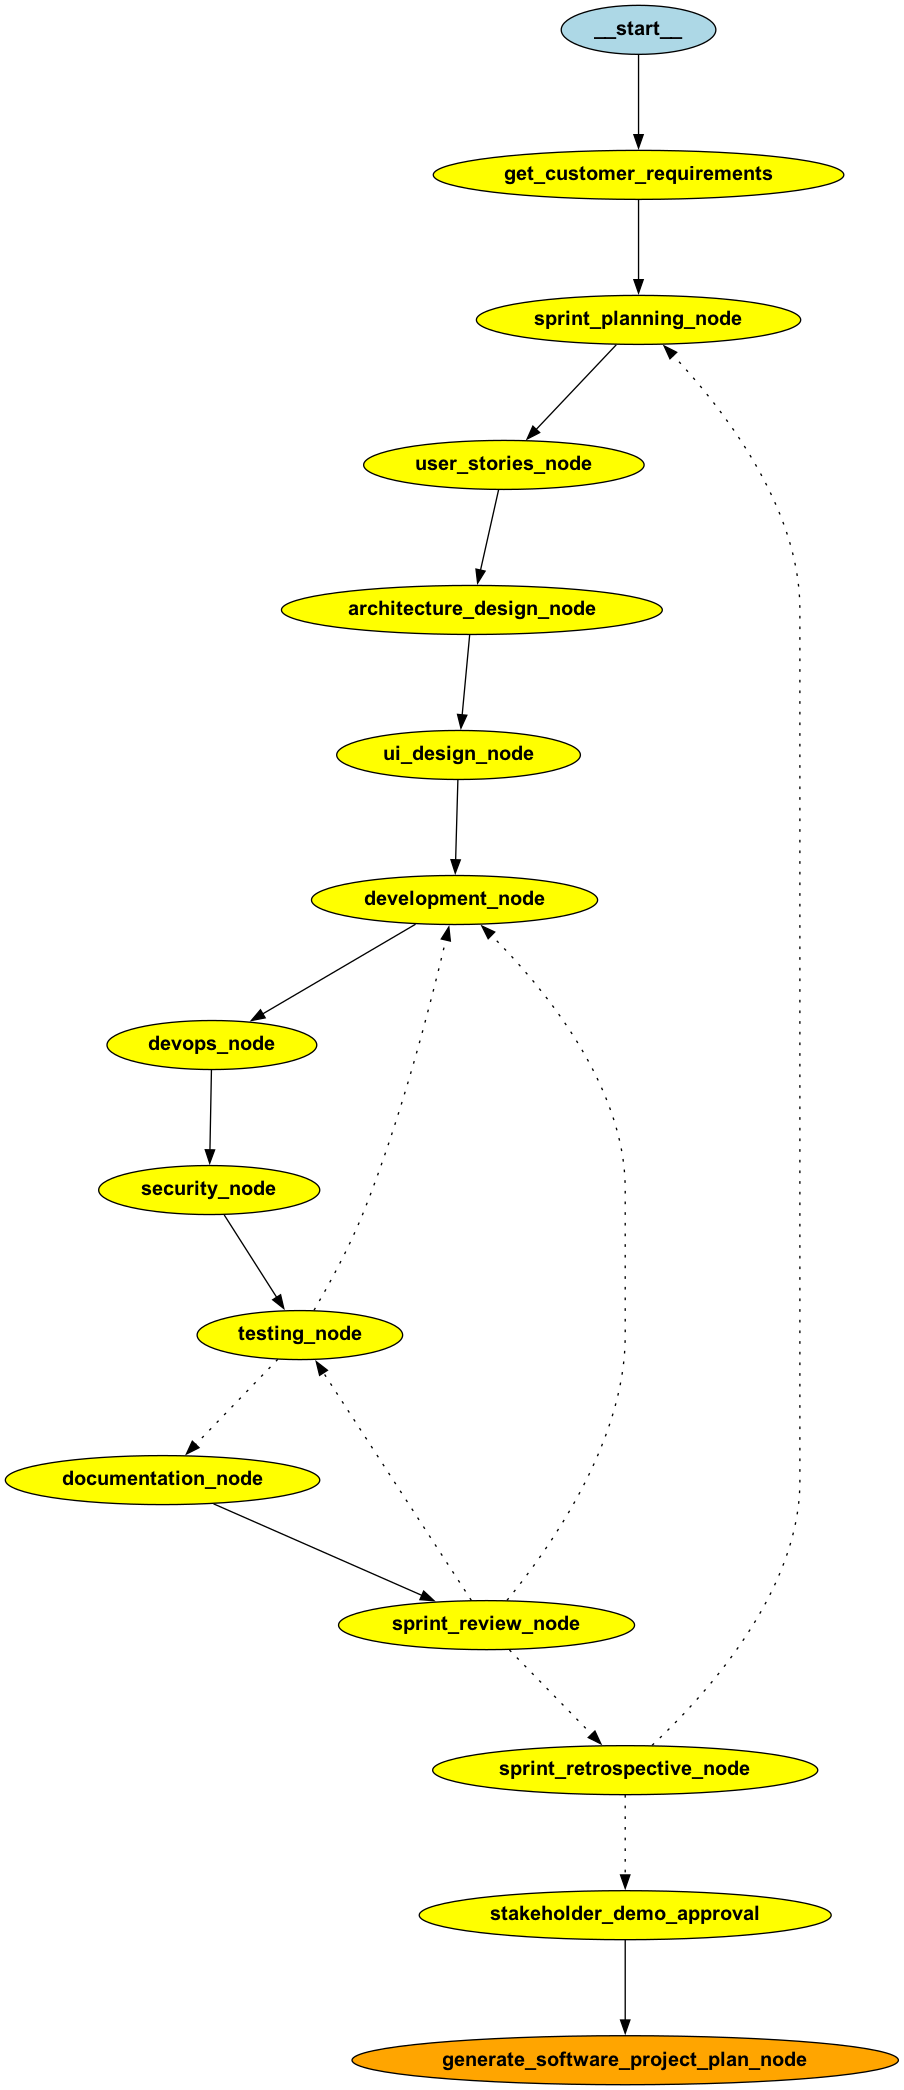

In [8]:
from IPython.display import Image
Image(graph.get_graph().draw_png())